In [1]:
import cv2 as cv
import random
import os
import matplotlib.pyplot as plt

In [2]:
test_path = "/Users/marianata/www/vision_fraud_prevention/dataset_fruits_vegs/test/test"

In [30]:
def show_any_image():
    while True:
        file_name = random.choice(os.listdir(test_path))
        
        if file_name.endswith(".jpg"):
            img_path = os.path.join(test_path, file_name)
            img = cv.imread(img_path)
            
            if img is None:
                print("failed to load img: {file_name}")
                continue
                
            img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            plt.imshow(img_rgb)
            plt.show()
            break

In [17]:
def show_any_image_bbox():
    while True:
        file_name = random.choice(os.listdir(test_path))
        
        if file_name.endswith(".jpg"):
            img_path = os.path.join(test_path, file_name)
            img = cv.imread(img_path)
            
            if img is None:
                print(f"Failed to load image: {file_name}")
                continue

            annotation_file = os.path.splitext(img_path)[0] + ".txt"
            
            if not os.path.exists(annotation_file):
                print(f"Annotation file not found for {file_name}")
                continue
            
            # image dimensions
            img_height, img_width, _ = img.shape

            # extract bounding boxes
            with open(annotation_file, "r") as f:
                annotations = f.readlines()

            for annotation in annotations:
                class_id, x_center, y_center, width, height = map(float, annotation.strip().split())
                
                # i need to convert the relative coordinates to absolute pixel values
                x_center_abs = int(x_center * img_width)
                y_center_abs = int(y_center * img_height)
                width_abs = int(width * img_width)
                height_abs = int(height * img_height)

                # top-left corner of the bounding box
                x_min = int(x_center_abs - width_abs / 2)
                y_min = int(y_center_abs - height_abs / 2)
                x_max = int(x_center_abs + width_abs / 2)
                y_max = int(y_center_abs + height_abs / 2)

                cv.rectangle(img, (x_min, y_min), (x_max, y_max), (0, 255, 0), 10)
                #cv.putText(img, str(int(class_id)), (x_min, y_min - 5), cv.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

            img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

            plt.imshow(img_rgb)
            plt.axis('off')
            plt.show()
            break


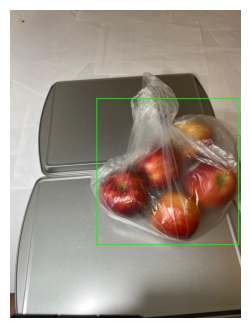

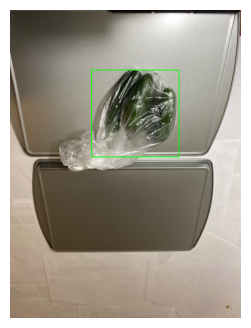

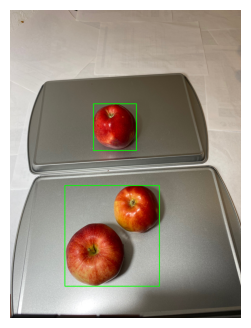

In [18]:
for i in range(3):
    plt.figure(figsize=(4,4))
    show_any_image_bbox()

In [32]:
#data size
train = os.listdir("/Users/marianata/www/vision_fraud_prevention/dataset_fruits_vegs/train/obj/") # your directory path
train_files = len(train)
print("Files in train:", train_files)

Files in train: 7884


In [34]:
test = os.listdir("/Users/marianata/www/vision_fraud_prevention/dataset_fruits_vegs/test/test") # your directory path
test_files = len(test)
print("Files in test:", test_files)

Files in test: 1301


#### Dataset
* 3942 imagenes de train
* 653 imagenes de test

### How many images have more than one annotation? in train and test

In [20]:
def count_images_with_multiple_bboxes(dataset_path):
    images_with_multiple_bboxes = 0
    total_images = 0
    
    for file_name in os.listdir(dataset_path):
        if file_name.endswith(".jpg"):
            total_images += 1
            annotation_file = os.path.splitext(os.path.join(dataset_path, file_name))[0] + ".txt"
            
            if os.path.exists(annotation_file):
                with open(annotation_file, "r") as f:
                    annotations = f.readlines()
                
                if len(annotations) > 1:
                    images_with_multiple_bboxes += 1
    
    return images_with_multiple_bboxes, total_images

In [21]:
train_path = "/Users/marianata/www/vision_fraud_prevention/dataset_fruits_vegs/train/obj/"

test_multiple_bboxes, test_total = count_images_with_multiple_bboxes(test_path)
train_multiple_bboxes, train_total = count_images_with_multiple_bboxes(train_path)

print(f"Test set: {test_multiple_bboxes}/{test_total} images have more than one bounding box.")
print(f"Train set: {train_multiple_bboxes}/{train_total} images have more than one bounding box.") 

Test set: 109/650 images have more than one bounding box.
Train set: 724/3942 images have more than one bounding box.


### Notes
It is important to notice this because I might need to handle this ltaer, for Yolo will output a pred for every object detected, so if in the image are 3 bananas, yolo or another algorithm, might output 3 preds while the annotations might online contain only one bbox.
I might measure the overlapping between bboxes. And define a certain threshold, if above threshold, the overlapping is high, ad hence the ground truth and predictions are close enough.

1) How much the predicted bounding boxes overlap with the ground truth bbox?


### Number of classes

In [1]:
import os

labels_path = 'dataset_fruits_vegs/train/labels'
labels_test =  'dataset_fruits_vegs/test/labels'

class_indices = set()

for filename in os.listdir(labels_test):
    if filename.endswith('.txt'):
        with open(os.path.join(labels_test, filename), 'r') as file:
            for line in file:
                parts = line.strip().split()
                if parts:  
                    class_index = int(parts[0])  
                    class_indices.add(class_index)  #

num_classes = len(class_indices)
print(f'Number of different classes in training data: {num_classes}')

Number of different classes in training data: 14


### Class names

In [8]:
import pandas as pd

# get a list of all the .txt files in the directory
filenames = [f for f in os.listdir(labels_path) if f.endswith('.txt')]
df = pd.DataFrame(filenames, columns=['filename'])

def extract_class_name(filename):
    '''
    Extracts class name and adjusts for bag status.
    '''
    parts = filename.split('_')
    if len(parts) > 2:
        fruit_name = parts[2]
        
        # remove any unwanted suffixes (e.g., ' - 11.txt')
        fruit_name = fruit_name.split(' - ')[0] 
        
        # check if the filename indicates a bag
        if 'wb' in filename: 
            return f"{fruit_name}-bag"
        elif 'wob' in filename:
            return f"{fruit_name}"
        else:
            return fruit_name
    return None

In [10]:
df['class_name'] = df['filename'].apply(extract_class_name)
unique_classes = df['class_name'].unique()

In [17]:
print(len(unique_classes))

# convert to list
unique_classes_sorted = sorted(unique_classes)
print("Class names", unique_classes_sorted)

14
Class names ['apple', 'apple-bag', 'banana', 'banana-bag', 'blackberries', 'chilli', 'chilli-bag', 'grapes', 'grapes-bag', 'lemon', 'lemon-bag', 'raspberry', 'tomato', 'tomato-bag']
